In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
#read the reviews
restaurant_file = pd.read_csv('processed_data/restaurants_az.csv')
restaurant_file = restaurant_file.drop(labels="Unnamed: 0", axis=1)
review_file     = pd.read_csv('processed_data/reviews_az.csv')
review_file     = review_file.drop(labels="Unnamed: 0", axis=1) 

In [3]:
#Check the review file
review_file.head(3)

,business_id,name,city,state,business_stars,review_count,categories,review_id,user_id,review_stars,useful,text,date,cleansed_text
0,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",QgV9RPyPUC3cAse1Wxqoow,P3cMpkppvBuVpPD8LBTbBQ,4.0,2,Enjoyed Nee House immensely. No service issues...,2012-04-28 21:08:22,enjoy immensely. no service issue fantastic ch...
1,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",1ZTO6zFtVVxtXclHp4TvHQ,b1yLsCdv4ZL_d3INMCZzoA,3.0,0,I'm not sure how I rate this restaurant becaus...,2017-02-09 05:15:25,not sure rate because walk soup. 4 p.m. destro...
2,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",h17ep5S7O8_JMKovooWoVA,TaVuQWmXAhxy_LvIXBs9sg,5.0,0,The food from this place reminds me of home. I...,2016-08-12 21:38:55,food place remind home. taiwanese little islan...


In [4]:
#check the restuarant file
restaurant_file.head(3)

,business_id,name,city,state,stars,review_count,categories
0,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants"
1,r8764MtYyt8JhxMvrfM_xQ,Vintage 95,Chandler,AZ,4.0,320,"American (New), Bars, Wine Bars, Nightlife, Re..."
2,voZnDQs6Hs3YpNcS-9TALg,New Mexican Grill,Chandler,AZ,4.0,84,"Restaurants, Mexican"


In [5]:
review_file['review_length'] = review_file.text.map(len)
review_file.head(1)

,business_id,name,city,state,business_stars,review_count,categories,review_id,user_id,review_stars,useful,text,date,cleansed_text,review_length
0,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",QgV9RPyPUC3cAse1Wxqoow,P3cMpkppvBuVpPD8LBTbBQ,4.0,2,Enjoyed Nee House immensely. No service issues...,2012-04-28 21:08:22,enjoy immensely. no service issue fantastic ch...,263


[Text(-14.45000000000001, 0.5, 'Number of Reviews')]

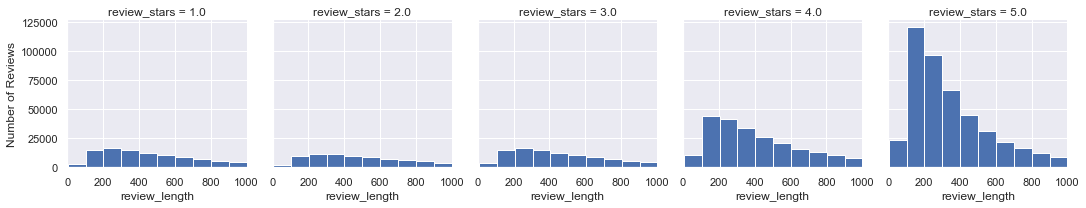

In [6]:
#let's check the distribution of the reviews by length of comments
ax = sns.FacetGrid(data=review_file, col='review_stars', xlim=(0, 1000)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='Number of Reviews')

In [7]:
#It's interesting that five star reivews are more verbose
#print(review_file.loc[review_file['review_stars']==1.0])


In [8]:
p_reviews = review_file.text[review_file.review_stars>3].values
n_reviews = review_file.text[review_file.review_stars<3].values
print('Postive  Reviews: {:,}'.format(len(p_reviews)))
print('Negative Reviews: {:,}'.format(len(n_reviews)))

Postive  Reviews: 736,919
Negative Reviews: 216,632


In [9]:
#Take our additional stopwords
from sklearn.feature_extraction import text
extra_words = ['like','did','said','ok', 've', 'got']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [10]:
%%time
#TF-IDF


from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(19)
num_reviews = 20000
random_neg = np.random.choice(n_reviews, size=num_reviews)
random_pos = np.random.choice(p_reviews, size=num_reviews)

dicty = {'pizzas':'pizza', 'burgers':'burger', 'ordered':'order',
         'prices':'price', 'topping':'toppings'}
def replace_words(text, dicty):
    '''Returns text with word substitutions made according
       to the passed `dicty` dictionary'''
    for i,j in dicty.items():
        text = text.replace(i,j)
    return text

random_n = [replace_words(w, dicty) for w in random_neg]
random_p = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
n_vectors = tfidf_neg.fit_transform(random_neg)
p_vectors = tfidf_pos.fit_transform(random_pos)

Wall time: 3.34 s


In [11]:
%%time
# Store TFIDF vectors in a Pandas DataFrame to investigate further
n_df = pd.DataFrame(n_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
p_df = pd.DataFrame(p_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each column (word): highest means are most important words
col_means_neg = {}
for col in n_df:
    col_means_neg[col] = n_df[col].mean()

col_means_pos = {}
for col in p_df:
    col_means_pos[col] = p_df[col].mean()

Wall time: 28.6 s


In [12]:
no_top_words = 20
print('Top %d words in Positive reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])
print('Top %d words in Negative reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

Top 20 words in Positive reviews:[('great',), ('food',), ('good',), ('place',), ('service',), ('love',), ('best',), ('time',), ('delicious',), ('amazing',), ('really',), ('friendly',), ('just',), ('pizza',), ('staff',), ('nice',), ('chicken',), ('definitely',), ('try',), ('restaurant',)]
Top 20 words in Negative reviews:[('place',), ('service',), ('good',), ('just',), ('time',), ('order',), ('ordered',), ('minutes',), ('came',), ('don',), ('chicken',), ('restaurant',), ('didn',), ('really',), ('great',), ('bad',), ('asked',), ('went',), ('pizza',), ('table',)]


In [13]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_pos_corpus = matutils.Sparse2Corpus(p_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(n_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)

In [14]:
# create LSA model
num_topics = 10
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=num_topics)

In [16]:
topics_to_print = 5

# look at top positive topics
print('Top %d topics for POSITIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_pos.show_topics()[0:topics_to_print])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0,
  '0.285*"great" + 0.274*"food" + 0.241*"good" + 0.236*"place" + '
  '0.188*"service" + 0.141*"love" + 0.128*"time" + 0.124*"really" + '
  '0.119*"friendly" + 0.119*"amazing"'),
 (1,
  '-0.566*"great" + 0.294*"pizza" + -0.293*"food" + -0.263*"service" + '
  '0.155*"good" + 0.142*"chicken" + -0.125*"atmosphere" + 0.121*"ordered" + '
  '0.115*"just" + 0.108*"sauce"'),
 (2,
  '0.850*"pizza" + 0.210*"great" + 0.123*"crust" + -0.114*"chicken" + '
  '-0.108*"good" + 0.102*"wings" + 0.089*"love" + -0.081*"food" + '
  '-0.073*"rice" + -0.070*"tacos"'),
 (3,
  '-0.531*"good" + 0.496*"love" + 0.248*"place" + 0.242*"best" + '
  '0.219*"amazing" + -0.176*"great" + -0.165*"really" + -0.160*"service" + '
  '0.144*"favorite" + 0.111*"sushi"'),
 (4,
  '0.530*"good" + 0.367*"love" + 0.331*"place" + 0.206*"sushi" + '
  '-0.199*"great" + 0.148*"really" + -0.148*"amazing" + -0.134*"delicious" + '
  '-0.110*"ordered" + -0.098*"service

In [17]:
topics_to_print = 5
# look at top negative topics
print('Top %d topics for NEGATIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_neg.show_topics()[0:topics_to_print])

Top 5 topics for NEGATIVE reviews
---------------------------------
[(0,
  '0.188*"place" + 0.188*"service" + 0.167*"good" + 0.163*"just" + '
  '0.161*"order" + 0.160*"time" + 0.144*"minutes" + 0.131*"ordered" + '
  '0.126*"came" + 0.111*"didn"'),
 (1,
  '0.312*"minutes" + -0.256*"chicken" + 0.190*"order" + -0.174*"good" + '
  '0.152*"waited" + -0.147*"pizza" + -0.143*"sauce" + 0.139*"service" + '
  '0.131*"table" + 0.129*"wait"'),
 (2,
  '0.892*"pizza" + 0.138*"order" + 0.137*"crust" + 0.095*"wings" + '
  '-0.087*"chicken" + -0.079*"sushi" + 0.073*"delivery" + 0.067*"cheese" + '
  '-0.065*"rice" + 0.061*"toppings"'),
 (3,
  '0.361*"service" + -0.309*"chicken" + 0.289*"place" + -0.233*"order" + '
  '-0.216*"ordered" + -0.207*"minutes" + -0.142*"came" + 0.137*"good" + '
  '-0.136*"salad" + 0.125*"customer"'),
 (4,
  '-0.464*"order" + 0.209*"bar" + 0.201*"table" + 0.195*"server" + '
  '-0.179*"customer" + 0.172*"pizza" + -0.168*"time" + 0.155*"came" + '
  '-0.150*"chicken" + -0.138*"call

In [18]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(p_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(n_vectors)
H_neg = nmf_neg.components_

Wall time: 4.58 s


In [19]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   0.938*chicken, 0.791*just, 0.786*time, 0.727*ordered, 0.636*delicious, 0.592*salad
Topic 1:   2.567*great, 1.318*service, 1.214*food, 0.523*atmosphere, 0.435*excellent, 0.299*awesome
Topic 2:   2.967*pizza, 0.450*crust, 0.326*wings, 0.184*pizzas, 0.176*toppings, 0.176*cheese
Topic 3:   1.777*place, 1.668*love, 0.809*best, 0.757*staff, 0.735*amazing, 0.677*friendly
Topic 4:   3.155*good, 1.063*really, 0.876*food, 0.471*place, 0.461*nice, 0.408*pretty
Topic 5:   2.134*sushi, 0.972*happy, 0.908*hour, 0.542*rolls, 0.532*roll, 0.224*best

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.370*minutes, 1.110*table, 1.038*came, 0.898*server, 0.796*asked, 0.766*waited
Topic 1:   1.288*chicken, 0.729*ordered, 0.581*sauce, 0.578*salad, 0.522*rice, 0.519*cheese
Topic 2:   2.999*pizza, 0.478*crust, 0.301*wings, 0.277*cheese, 0.236*sauce, 0.213*toppings
Topic 3:   1.6

In [20]:
# look at a random positive and negative reviews
print('Positive Review')
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])

print('\nNegative Review')
review_num = np.random.randint(0, high=len(random_neg))
print(review_num)
print(random_neg[review_num])


Positive Review
8489
There are 365 days in a year, and I am at Cabin Coffee for about 358 of them. I love this place! Every morning all the girls (and occasionally guys) get my ridiculous drink created with perfection and a great attitude! You will not find a better cup of caffeinated beverage then Cabin Coffee. And literally everything is good here. From my daily 5 shot espresso (which by the way is the smoothest and richest espresso I have ever had) to the "honey bear" or "maple leaf" lattes and even the amazing sweet treats like those yummy sticky buns. If you live in the north west valley and haven't been to Cabin Coffee then you need to. Go get that coffee right now! You will be treated with a great cup of joe   and an awesome and cozy environment, provided by an fantastic staff of baristas! Thanks guys.

Negative Review
9527
We love the location on the west side and was very excited to try this place however it turned out to be the biggest disappointment. We didn't even get to tr

In [21]:
# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [22]:
# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 0.962
I'm torn between shouting from the rooftops about how much I love Arrivederci's happy hour and keeping it as my own little secret so it doesn't become overcrowded.  Well . . . here it goes, fingers crossed!

We had been here for dinner a few times and were very pleased, we decided we needed to try their happy hour.  I'm so glad we did; this is one of my new favorite quiet happy hour spots.  Not quite as trendy as Va Bene, but that's a good thing.  Less of a singles scene, less noisy and the food is just as delicious!  Happy hour is M-F 5-7.

We walked in a few minutes after 5 and were greeted by a very friendly bartender.  He kindly brought us menus and explained that during happy hour all wines by the glass are $5.  Wonderful!! He brought us some water (with a slice of cucumber, nice touch), took our drink orders, and gave us a few minutes to decide on food.

In addition to the wine specials, there are happy hour f

In [23]:

from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(n_reviews, size=num_reviews)
cv_random_pos = np.random.choice(p_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [24]:

# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [25]:
print('Postive Reviews:  {:,}'.format(len(p_reviews)))
print('Negative Reviews:  {:,}'.format(len(n_reviews)))

Postive Reviews:  736,919
Negative Reviews:  216,632


In [26]:

%%time
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words with defined dictionary 'dicty'
pos_reviews = [replace_words(w, dicty) for w in p_reviews]
neg_reviews = [replace_words(w, dicty) for w in n_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(n_reviews)
pos_vectors = tfidf_pos.fit_transform(p_reviews)

Wall time: 1min 18s


In [27]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 2min 4s


In [28]:

no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   2.282*chicken, 1.877*time, 1.820*just, 1.761*ordered, 1.615*delicious, 1.420*salad
Topic 1:   6.102*great, 3.160*service, 2.849*food, 1.256*atmosphere, 1.064*excellent, 0.762*awesome
Topic 2:   7.048*pizza, 1.224*crust, 0.858*wings, 0.572*best, 0.424*pizzas, 0.419*cheese
Topic 3:   4.346*place, 3.819*love, 1.889*amazing, 1.880*staff, 1.824*friendly, 1.786*best
Topic 4:   7.635*good, 2.582*really, 1.904*food, 1.155*nice, 1.110*pretty, 1.042*service
Topic 5:   4.489*sushi, 2.767*happy, 2.628*hour, 1.165*roll, 1.037*rolls, 0.487*bar

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   3.203*place, 1.713*just, 1.696*good, 1.449*really, 1.397*don, 0.949*great
Topic 1:   2.453*chicken, 1.442*ordered, 1.102*sauce, 1.099*salad, 1.002*rice, 0.914*cheese
Topic 2:   5.358*pizza, 0.798*crust, 0.558*wings, 0.531*cheese, 0.373*sauce, 0.357*pizzas
Topic 3:   2.437*minutes, 1.964*table, 1.707*came

In [29]:

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'time/order/service', 1:'service/atmosphere', 2:'service/pizza', 
              3:'serivce/atmosphere/staff', 4:'friendly_staff', 5:'bar/happy_hour'}

neg_topics = {0:'beer/people', 1:'food/chicken/salad', 2:'food/pizza', 
              3:'wait/table', 4:'order/time/location', 5:'bad_service'}

In [30]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = review_file[['business_id', 'review_stars', 'text', 'review_length']][review_file.review_stars>3].reset_index()
df_neg = review_file[['business_id', 'review_stars', 'text', 'review_length']][review_file.review_stars<3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

In [31]:

print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.01274134 0.01938411 0.         0.00407995 0.0027115  0.        ]
Sum of weights:  0.03891689170199594


In [32]:

from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.32739864 0.49808983 0.         0.10483746 0.06967407 0.        ]]
Sum of normalized weights:  1.0


In [33]:

# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [34]:

# peek into a dataframe to ensure it worked right
df_neg.head()

,business_id,review_stars,text,review_length,0,1,2,3,4,5
0,44YFU284Z3KDEy25QyVoUw,2.0,This 2 star rating is for the service. Althoug...,518,0.012415,0.013928,0.000000,0.760511,0.000000,0.213146
1,44YFU284Z3KDEy25QyVoUw,2.0,After reading many decent reviews and seeing h...,258,0.834317,0.071897,0.010393,0.000000,0.070177,0.013216
2,44YFU284Z3KDEy25QyVoUw,1.0,The service to grab a seat is slow like 20 min...,366,0.046787,0.004027,0.000404,0.405789,0.300758,0.242234
3,44YFU284Z3KDEy25QyVoUw,2.0,Very disappointed with the lack of flavor in t...,195,0.000000,0.813191,0.016033,0.000000,0.128457,0.042319
4,44YFU284Z3KDEy25QyVoUw,1.0,The wait staff is as nasty as the food. RUDE A...,448,0.039458,0.382742,0.000000,0.111113,0.000000,0.466687


In [35]:

# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'review_stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'review_stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()

In [36]:
df_pos_bsns.head(5)

,business_id,review_stars,text,review_length,0,1,2,3,4,5
0,-01XupAWZEXbdNbxNg5mEg,4.488889,45,593.666667,0.256016,0.254983,0.047231,0.163278,0.173443,0.105050
1,-050d_XIor1NpCuWkbIVaQ,4.545120,543,766.480663,0.385385,0.114889,0.013322,0.300914,0.143474,0.042015
2,-092wE7j5HZOogMLAh40zA,4.600000,55,539.727273,0.329510,0.152820,0.014533,0.258739,0.188905,0.055493
3,-0WegMt6Cy966qlDKhu6jA,4.307692,13,467.769231,0.291615,0.237132,0.018235,0.148809,0.220965,0.083244
4,-0tgMGl7D9B10YjSN2ujLA,4.421053,76,399.671053,0.187277,0.308735,0.018388,0.205323,0.201018,0.079258


In [37]:
df_neg_bsns.head()

,business_id,review_stars,text,review_length,0,1,2,3,4,5
0,-01XupAWZEXbdNbxNg5mEg,1.421053,38,601.789474,0.365444,0.178131,0.037723,0.177224,0.080320,0.161158
1,-050d_XIor1NpCuWkbIVaQ,1.607143,84,922.940476,0.451230,0.150766,0.014057,0.204198,0.109618,0.070132
2,-092wE7j5HZOogMLAh40zA,1.294118,34,630.970588,0.157546,0.472303,0.013131,0.042274,0.219311,0.095435
3,-0WegMt6Cy966qlDKhu6jA,1.357143,70,639.171429,0.289390,0.072532,0.013121,0.280011,0.112165,0.232782
4,-0tgMGl7D9B10YjSN2ujLA,1.416667,36,541.527778,0.368271,0.092633,0.007106,0.265700,0.083006,0.183284


In [38]:
# we can read in business info from a saved CSV file
# and add that to our last dataframe

az_df = pd.read_csv('processed_data/restaurants_az.csv')
az_df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [39]:
# merge business name/city with topic data
df_pos_tot = df_pos_bsns.merge(az_df[['business_id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars', 0, 1, 2, 3, 4, 5]]

df_neg_tot = df_neg_bsns.merge(az_df[['business_id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars', 0, 1, 2, 3, 4, 5]]

In [40]:
# peek into business/topic distributions
df_pos_tot.head()

,business_id,name,city,stars,0,1,2,3,4,5
0,-01XupAWZEXbdNbxNg5mEg,18 Degrees,Scottsdale,3.0,0.256016,0.254983,0.047231,0.163278,0.173443,0.105050
1,-050d_XIor1NpCuWkbIVaQ,Matt's Big Breakfast,Phoenix,4.0,0.385385,0.114889,0.013322,0.300914,0.143474,0.042015
2,-092wE7j5HZOogMLAh40zA,Wong's Jr,Peoria,3.0,0.329510,0.152820,0.014533,0.258739,0.188905,0.055493
3,-0WegMt6Cy966qlDKhu6jA,Game Seven Grill,Phoenix,2.0,0.291615,0.237132,0.018235,0.148809,0.220965,0.083244
4,-0tgMGl7D9B10YjSN2ujLA,Dubliner,Phoenix,3.5,0.187277,0.308735,0.018388,0.205323,0.201018,0.079258


In [48]:

scores = df_pos_bsns[df_pos_bsns.business_id == '-0tgMGl7D9B10YjSN2ujLA'].iloc[:,-6:].values
print(az_df[az_df.business_id == '-0tgMGl7D9B10YjSN2ujLA']['name'].values[0] + ' - Positive Reviews')
print('-'*36)
for n in pos_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, pos_topics[n], scores[0][n]))

Dubliner - Positive Reviews
------------------------------------
Topic 0: time/order/service > 0.1873
Topic 1: service/atmosphere > 0.3087
Topic 2: service/pizza      > 0.0184
Topic 3: serivce/atmosphere/staff > 0.2053
Topic 4: friendly_staff     > 0.2010
Topic 5: bar/happy_hour     > 0.0793


In [41]:

%%time
# write to CSV
df_pos_tot.to_csv('processed_data/pos_bsns.csv')
df_neg_tot.to_csv('processed_data/neg_bsns.csv')
df_pos.to_csv('processed_data/pos_reviews.csv')
df_neg.to_csv('processed_data/neg_reviews.csv')

Wall time: 30 s
